# TASK 2- Color Identification using Machine Learning

I have used machine learning algorithm, `KMeans`, to extract colors from a give image. I will use `OpenCV2` for image manipulation, apply `KMeans` to identify the major colors and then plot the information using `Matplotlib`.

**STEP 1: Import libraries**

Let's first import necessary libraries. We need `sklearn` for KMeans algorithm, `matplotlib.pyplot` for plotting graphs, `numpy` to work with arrays, `cv2` to work with image data, `collections` to use Counter to count values, `rgb2lab` to convert RGB values and `deltaE_cie76` to calculate similarity between colors.

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

%matplotlib inline

**STEP 2: Working with OpenCV**

Let's first read a sample image and understand basic operations that we can do on it.

The type of this input is <class 'numpy.ndarray'>
Shape: (3456, 4608, 3)


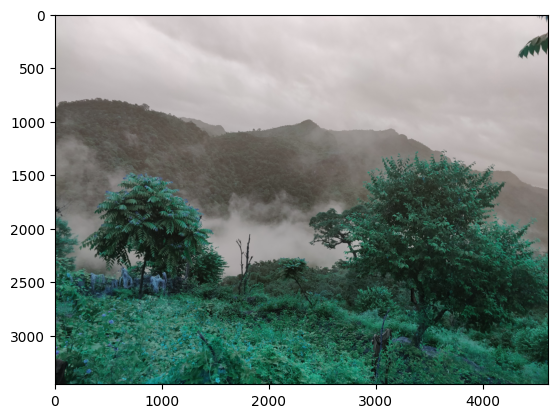

In [2]:
image = cv2.imread('sample_image.jpg')
print("The type of this input is {}".format(type(image)))
print("Shape: {}".format(image.shape))
plt.imshow(image)

We see that the image has different colors as compared to the original image. This is because by default OpenCV reads the images in the color order `BLUE GREEN RED` i.e. BGR. Thus, we need to convert it into `REG GREEN BLUE` i.e. RGB.

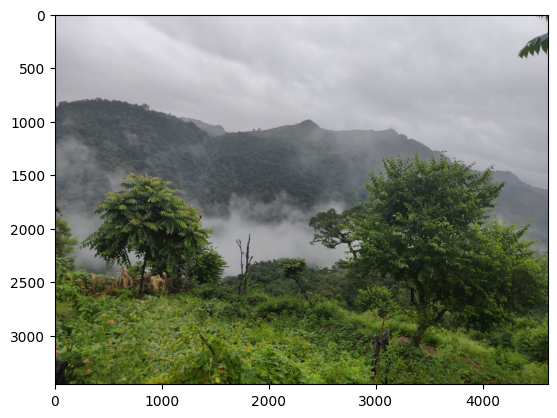

In [3]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

The image can also be converted to grayscale if needed.

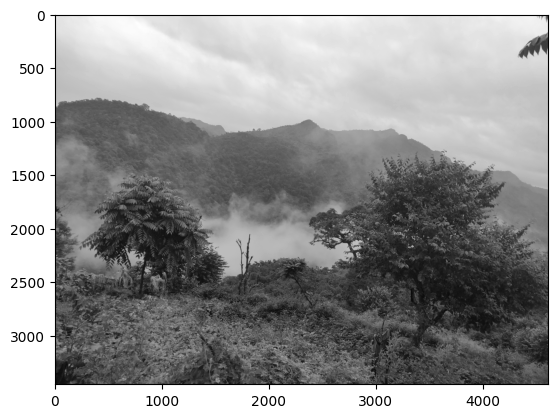

In [4]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')

We might want to resize the image to a certain size whenever the images are huge or when we are working with multiple images of different dimensions.

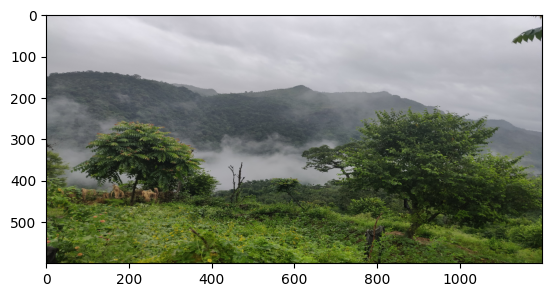

In [5]:
resized_image = cv2.resize(image, (1200, 600))
plt.imshow(resized_image)

## Color Identification

Not that we know a bit about OpenCV, let's start identifying colors from an image.

First, we will define a function that can give us the `hex` values of our the colors that we will identify.

In [6]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

KMeans expects flattened array as input during its fit method. Thus, we need to reshape the image using numpy. Then, we can apply KMeans to first fit and then predict on the image to get the results. Then, the cluster colors are identified an arranged in the correct order. We plot the colors as a pie chart.

I have combined all the steps in two method.

In [7]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [9]:
def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

[array([55.76904817, 68.81750811, 34.55821561]),
 array([179.42798622, 180.01530072, 186.42285885]),
 array([120.64845555, 125.2279028 , 125.23046975]),
 array([110.85506685, 126.16043402,  57.54724537]),
 array([30.81473112, 39.34956393, 21.49193178]),
 array([206.54114052, 206.24043949, 213.72127354]),
 array([83.84356076, 90.71729915, 91.92874445]),
 array([79.90797072, 97.85529849, 38.6513775 ])]

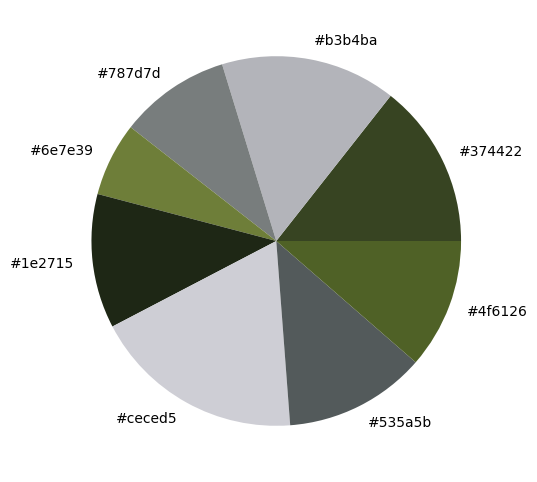

In [10]:
get_colors(get_image('sample_image.jpg'), 8, True)

## Search images using Color

From the model above, we can extract the major colors. 
This create the opportunity to search for images based on certain colors. We can select a color and if it's hex matches or is close to the hex of the major colors of the image, we say it's a match.

We first get all the images and store them in the `images` variable.

In [11]:
IMAGE_DIRECTORY = 'images'
COLORS = {
    'GREEN': [0, 128, 0],
    'BLUE': [0, 0, 128],
    'YELLOW': [255, 255, 0]
}
images = []

for file in os.listdir(IMAGE_DIRECTORY):
    if not file.startswith('.'):
        images.append(get_image(os.path.join(IMAGE_DIRECTORY, file)))

We can now see all the images.

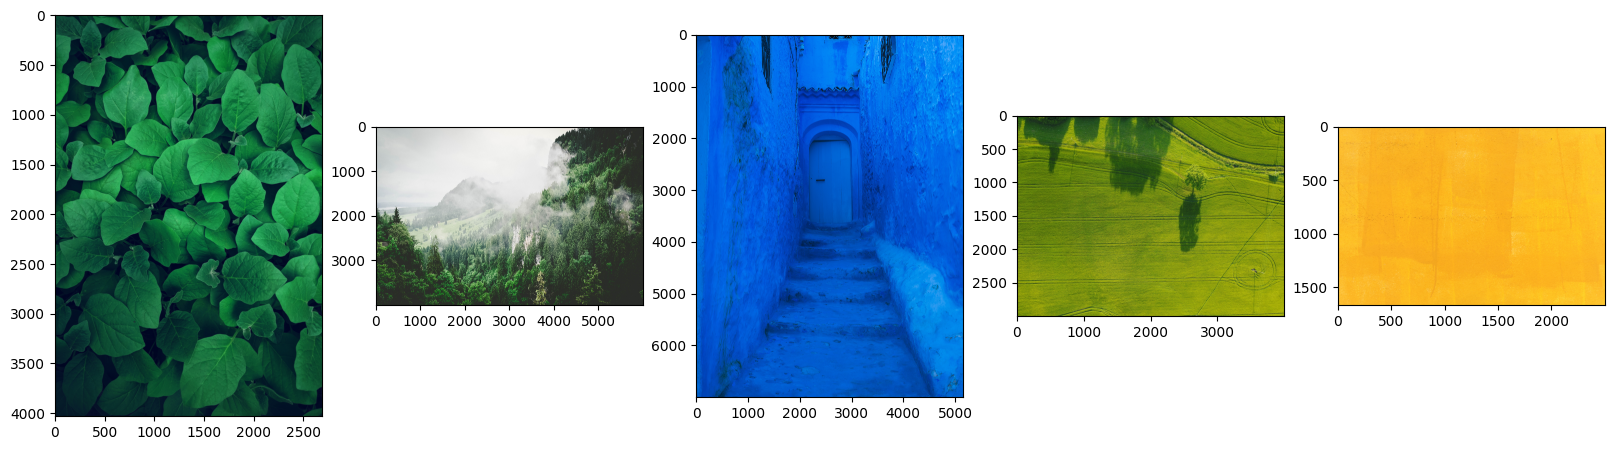

In [12]:
plt.figure(figsize=(20, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])

We define the function below. We will try to match with the top 10 colors of the image. It is highly possible that there will be no extact match for the hex codes, thus we calculate the similarity between the chosen color and the colors of the image. 

We keep a threshold value such that if the difference between the chosen color and any of the selected colors is less than that threshold, we declare it as a match.

Hex values or RGB values cannot be directly compared so we first convert them to a device independant and color uniform space. We use `rgb2lab` to convert the values and then find the difference using `deltaE_cie76`. The method calculates the difference between all top 5 colors of the image and the selected color and if atleast one is below the threshold, we show the image.

In [13]:
def match_image_by_color(image, color, threshold = 60, number_of_colors = 10): 
    
    image_colors = get_colors(image, number_of_colors, False)
    selected_color = rgb2lab(np.uint8(np.asarray([[color]])))

    select_image = False
    for i in range(number_of_colors):
        curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
        diff = deltaE_cie76(selected_color, curr_color)
        if (diff < threshold):
            select_image = True
    
    return select_image

We call the above method for all the images in our set and show relevant images out of the same that approximately match our selected color.

In [14]:
def show_selected_images(images, color, threshold, colors_to_match):
    index = 1
    
    for i in range(len(images)):
        selected = match_image_by_color(images[i],
                                        color,
                                        threshold,
                                        colors_to_match)
        if (selected):
            plt.subplot(1, 5, index)
            plt.imshow(images[i])
            index += 1

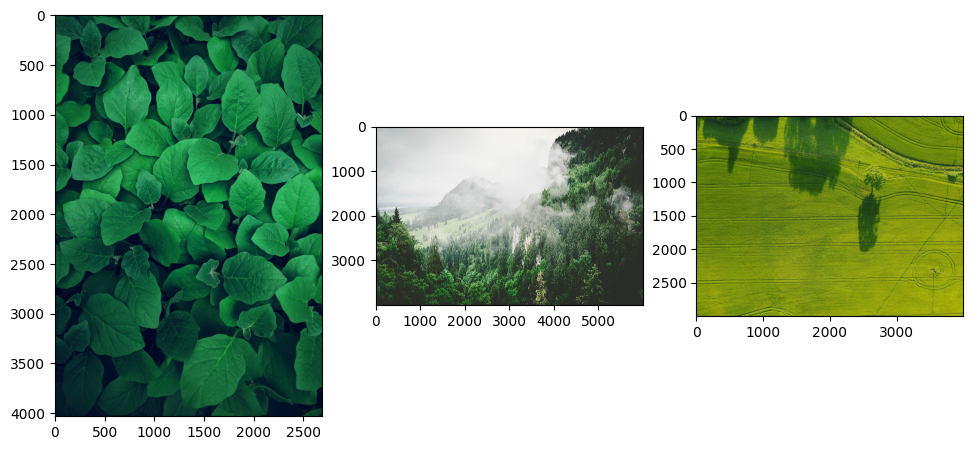

In [15]:
# Search for GREEN
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['GREEN'], 60, 5)

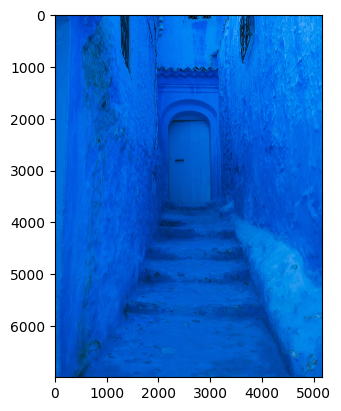

In [16]:
# Search for BLUE
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['BLUE'], 60, 5)

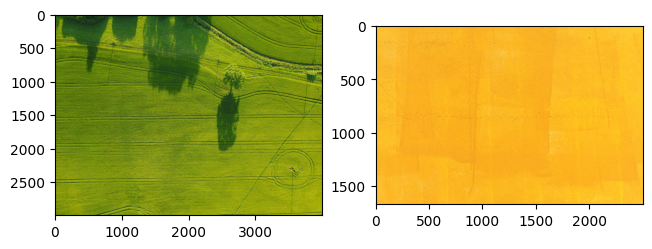

In [17]:
# Search for YELLOW
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['YELLOW'], 60, 5)

## Conclusion

In this notebook, we used KMeans to extract majority colors from images. We then used the RGB Values of Colors to identify images from a collection that have that color in them.